#   Solve Burgers' Equation with PINN

In this example, we would like to show you another example of how to use ConFIG method to train a physics informed neural network (PINN) for solving a PDE. 

<a target="_blank" href="https://colab.research.google.com/github/tum-pbs/ConFIG/blob/main/docs/examples/pinn_burgers.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this example, we will solve the 1D Burgers' equation:

$$
    \frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=\nu \frac{\partial^{2} u}{\partial x^{2}}
$$

where $\nu$ is the viscosity and set as $\nu=0.01/\pi$ in the current study. The spatial-temporal domain is $t \in [0,1]$ and $x \in [-1.0,1.0]$ with the corresponding initial and boundary conditions of

$$
\begin{cases}
u(x,0) = -\sin({\pi x})\\
u(+1.0,t) = u(-1.0,t) = 0 \\
\end{cases}
$$

Let's start by defining a dataset where we can sample points for the initial/boundary conditions and the internal domain:

In [1]:
import torch
from typing import Callable,Union
import numpy as np
from scipy.stats.qmc import LatinHypercube

class BurgersDataset():
    
    def __init__(self,
                 x_start:float=-1.0,x_end:float=1.0,ini_boundary:Callable=lambda x: -1*torch.sin(np.pi*x),simulation_time:float=1.0,
                 n_pde:int=2000,n_initial:int=50,n_boundary:int=50,device:Union[str,torch.device]="cpu",
                 nu=0.01/np.pi,
                 seed:int=21339,) -> None:
        self.ini_boundary=ini_boundary
        self.x_start=x_start
        self.x_end=x_end
        self.n_pde=n_pde
        self.n_boundary=n_boundary
        self.n_initial=n_initial
        self.nu=nu
        self.simulation_time=simulation_time
        self.device=device
        self.random_engine_initial_boundary=LatinHypercube(d=1,seed=seed)
        self.random_engine_pde=LatinHypercube(d=2,seed=seed)
    
    def sample_initial(self):
        with torch.no_grad():
            x_initial = torch.tensor(self.random_engine_initial_boundary.random(n=self.n_initial)[:,0],device=self.device,dtype=torch.float32)*(self.x_end-self.x_start)+self.x_start
            t_initial = torch.zeros_like(x_initial)
            value_initial = self.ini_boundary(x_initial)
            return (x_initial,t_initial,value_initial)
    
    def sample_boundary(self):
        with torch.no_grad():
            x_boundary = torch.cat([self.x_start*torch.ones(self.n_boundary//2,device=self.device),self.x_end*torch.ones(self.n_boundary//2,device=self.device)])
            t_boundary = torch.tensor(self.random_engine_initial_boundary.random(n=self.n_boundary)[:,0],device=self.device,dtype=torch.float32)
            value_boundary = torch.zeros_like(t_boundary,device=self.device)
            return (x_boundary,t_boundary,value_boundary)
    
    def sample_pde(self):
        sample = self.random_engine_pde.random(n=self.n_pde)
        x=torch.tensor(sample[:,0],device=self.device,dtype=torch.float32)*(self.x_end-self.x_start)+self.x_start
        x.requires_grad=True
        t=torch.tensor(sample[:,1],device=self.device,dtype=torch.float32)*self.simulation_time
        t.requires_grad=True
        return (x,t,self.nu)

Then, we can define a neural network with a simple MLP architecture:

In [2]:
import torch.nn as nn

class BurgersNet(nn.Module):
    
    def __init__(self,channel_basics=50,n_layers=4, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ini_net=nn.Sequential(nn.Linear(2, channel_basics), nn.Tanh())
        self.net=[]
        for i in range(n_layers):
            self.net.append(nn.Sequential(nn.Linear(channel_basics, channel_basics), nn.Tanh()))
        self.net=nn.Sequential(*self.net)
        self.out_net=nn.Sequential(nn.Linear(channel_basics, 1))
        
    
    def forward(self, x, t):
        ini_shape=x.shape
        y = torch.stack([x.view(-1), t.view(-1)], dim=-1)        
        y = torch.stack([x, t], dim=-1)
        y = self.ini_net(y)
        y = self.net(y)
        y = self.out_net(y)
        return y.view(ini_shape)

We can also a initialization function for the weights and biases. Here we use the Xavier initialization, which is a common initialization method for training PINNs:

In [ ]:
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, 1)
        m.bias.data.fill_(0.001)

Then, lets define the loss functions where we can calculate the loss for the initial/boundary conditions and the PDE separately:

In [3]:

class BurgersLoss(nn.Module):

    def _derivative(self, y: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
        for i in range(order):
            y = torch.autograd.grad(
                y, x, grad_outputs = torch.ones_like(y), create_graph=True, retain_graph=True
            )[0]
        return y

    def pde_loss(self,network,inputs):
        x,t,nu = inputs
        u=network(x,t)
        x.grad=None
        t.grad=None
        """ Physics-based loss function with Burgers equation """
        u_t = self._derivative(u, t, order=1)
        u_x = self._derivative(u, x, order=1)
        u_xx = self._derivative(u_x, x, order=1)
        return (u_t + u*u_x - nu * u_xx).pow(2).mean()
    
    def boundary_loss(self,network,inputs): 
        x_b,t_b,value_b=inputs
        boundary_loss=torch.mean((network(x_b,t_b)-value_b)**2)
        return boundary_loss
    
    def initial_loss(self,network,inputs):      
        x_i,t_i,value_i= inputs
        initial_loss=torch.mean((network(x_i,t_i)-value_i)**2)
        return initial_loss


Finally, we can define a tester class to record the best performance of the model during the training process:

In [4]:
import matplotlib.pyplot as plt
from ConFIG.utils import get_para_vector,apply_para_vector


class Tester():
    
    def __init__(self,
                 data_path="../../experiments/PINN/data/burgers/simulation_data.npy") -> None:
        self.simulation_data=torch.from_numpy(np.load(data_path)).to(dtype=torch.float32)
        self.x=torch.linspace(-1.0+1/256,1.0-1/256,256).unsqueeze(0).repeat(self.simulation_data.shape[0],1)
        self.t=torch.linspace(0,1.0,100).unsqueeze(1).repeat(1,self.simulation_data.shape[1])
        self.best_weight=None
        self.best_mse=100
    
    def _get_se(self,network):
        with torch.no_grad():
            device=network.parameters().__next__().device
            self.x=self.x.to(device)
            self.t=self.t.to(device)
            self.simulation_data=self.simulation_data.to(device)
            prediction=network(self.x,self.t)
            return (prediction-self.simulation_data).pow(2),prediction
    
    def test(self,network):
        with torch.no_grad():
            mse=self._get_se(network)[0].mean().item()
            if mse<self.best_mse:
                self.best_mse=mse
                self.best_weight=get_para_vector(network)
            return mse
    
    def plot_best(self,network):
        apply_para_vector(network,self.best_weight)
        se,prediction=self. _get_se(network)
        fig,ax=plt.subplots(1,3,figsize=(10,5))
        ax[0].imshow(self.simulation_data.cpu().detach().numpy().T)
        ax[0].set_title("simulation data")
        ax[1].imshow(prediction.cpu().detach().numpy().T)
        ax[1].set_title("prediction")
        im=ax[2].imshow(se.cpu().detach().numpy().T)
        ax[2].set_title("SE")
        plt.colorbar(im,ax=ax)
        plt.show()
        print(f"best mse: {self.best_mse}")
        


Now, let's train the network! we can first try with the classic Adam optimizer:

  0%|          | 0/5000 [00:00<?, ?it/s, current_mse=0.362, best_mse=0.362]

100%|██████████| 5000/5000 [01:13<00:00, 67.86it/s, current_mse=0.0319, best_mse=0.031] 


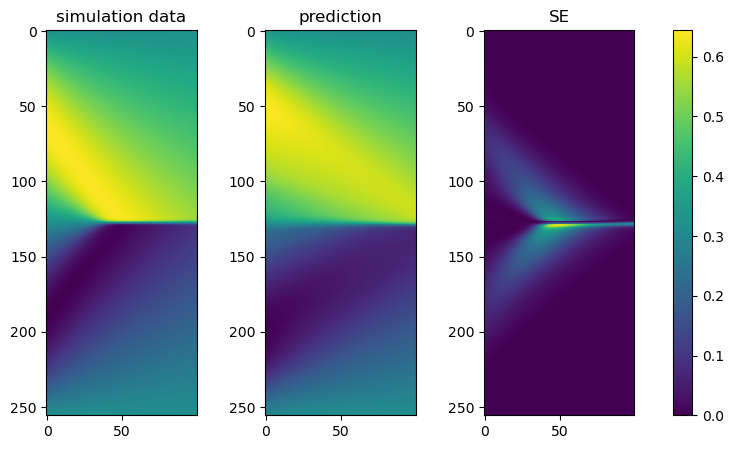

best mse: 0.030954960733652115


In [8]:
from torch.optim import Adam,SGD
from tqdm import tqdm

seed=19018
device="cuda:0"

torch.manual_seed(seed)
np.random.seed(seed)
net = BurgersNet()
net.apply(xavier_init_weights)
net.to(device)
optimizer=Adam(net.parameters(),lr=1e-4)
dataset=BurgersDataset(device=device,seed=seed)
loss=BurgersLoss()
tester=Tester()

p_bar=tqdm(range(5000))   
for i in p_bar:
    optimizer.zero_grad()
    loss_i=loss.initial_loss(net,dataset.sample_initial())
    loss_b=loss.boundary_loss(net,dataset.sample_boundary())
    loss_pde=loss.pde_loss(net,dataset.sample_pde())
    loss_total=loss_i+loss_b+loss_pde
    loss_total.backward()
    optimizer.step()
    p_bar.set_postfix({"current_mse":tester.test(net),"best_mse":tester.best_mse})
tester.plot_best(net)

Then, let's try to train the network with our ConFIG method:

  0%|          | 0/5000 [00:00<?, ?it/s, current_mse=0.39, best_mse=0.39]

100%|██████████| 5000/5000 [01:53<00:00, 43.91it/s, current_mse=0.00665, best_mse=0.00638]


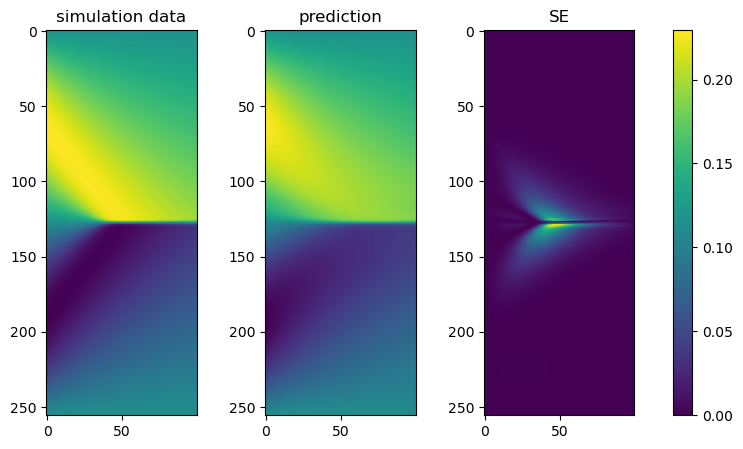

best mse: 0.006381959654390812


In [9]:
from ConFIG.grad_operator import ConFIG_update
from ConFIG.utils import get_gradient_vector,apply_gradient_vector

torch.manual_seed(seed)
np.random.seed(seed)
net = BurgersNet()
net.apply(xavier_init_weights)
net.to(device)
optimizer=Adam(net.parameters(),lr=1e-4)
dataset=BurgersDataset(device=device,seed=seed)
loss=BurgersLoss()
tester=Tester()

p_bar=tqdm(range(5000))   
for i in p_bar:
    grads=[]
    losses=[]
    for input_fn,loss_fn in zip([dataset.sample_initial,dataset.sample_boundary,dataset.sample_pde],
                                [loss.initial_loss,loss.boundary_loss,loss.pde_loss]):
        optimizer.zero_grad()
        loss_i=loss_fn(net,input_fn())
        loss_i.backward()
        grads.append(get_gradient_vector(net))
        losses.append(loss_i.item())
    apply_gradient_vector(net,ConFIG_update(grads))
    optimizer.step()
    p_bar.set_postfix({"current_mse":tester.test(net),"best_mse":tester.best_mse})
tester.plot_best(net)

As the results show, the ConFIG method can significantly improve the training accuracy of the PINN model. Now, lets try the momentum version of the ConFIG method:

  0%|          | 0/5000 [00:00<?, ?it/s, current_mse=0.358, best_mse=0.358]

100%|██████████| 5000/5000 [00:51<00:00, 96.80it/s, current_mse=0.00187, best_mse=0.00186]


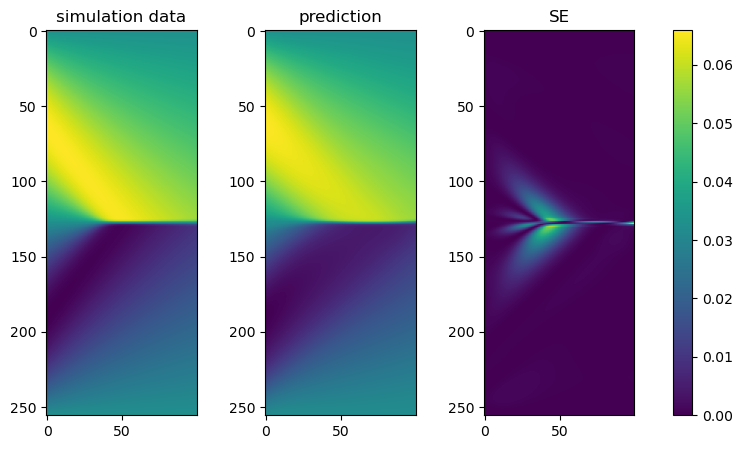

best mse: 0.0018616181332617998


In [10]:
from ConFIG.utils import OrderedSliceSelector
from ConFIG.momentum_operator import PseudoMomentumOperator

torch.manual_seed(seed)
np.random.seed(seed)
net = BurgersNet()
net.apply(xavier_init_weights)
net.to(device)
optimizer=SGD(net.parameters(),lr=5e-4)
dataset=BurgersDataset(device=device,seed=seed)
loss=BurgersLoss()
tester=Tester()

momentum_operator=PseudoMomentumOperator(num_vectors=3)
loss_selector=OrderedSliceSelector()
input_loss_fns=[(input_fn,loss_fn) for input_fn,loss_fn in zip(
    [dataset.sample_initial,dataset.sample_boundary,dataset.sample_pde],
    [loss.initial_loss,loss.boundary_loss,loss.pde_loss])]

p_bar=tqdm(range(5000))   
for i in p_bar:
    index,input_loss_fn=loss_selector.select(1,input_loss_fns)
    optimizer.zero_grad()
    loss=input_loss_fn[1](net,input_loss_fn[0]())
    loss.backward()    
    momentum_operator.update_gradient(net,index,grads=get_gradient_vector(net))
    optimizer.step()
    p_bar.set_postfix({"current_mse":tester.test(net),"best_mse":tester.best_mse})
tester.plot_best(net)

Although the accuracy of the momentum version of the ConFIG method is not as good as the original ConFIG method, it still outperforms the classic Adam optimizer. Meanwhile, the training speed is much faster than the original ConFIG method, even faster than the classic Adam optimizer.